<a href="https://colab.research.google.com/github/daotrananhtuan09102002/CS331.N12.KHCL/blob/main/Test_from_camera_using_YOLO_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load YOLOv7

In [ ]:
%%bash
git clone https://github.com/WongKinYiu/yolov7.git
cd yolov7
wget https://raw.githubusercontent.com/WongKinYiu/yolov7/u5/requirements.txt
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.9 MB/s eta 0:00:00


Cloning into 'yolov7'...
--2023-02-12 15:03:14--  https://raw.githubusercontent.com/WongKinYiu/yolov7/u5/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [text/plain]
Saving to: ‘requirements.txt.1’

     0K .                                                     100% 48.3M=0s

2023-02-12 15:03:14 (48.3 MB/s) - ‘requirements.txt.1’ saved [1032/1032]



# Define helper function

In [ ]:
from IPython.display import display, Javascript
import numpy as np
from google.colab.output import eval_js
from IPython.display import Image
import cv2
import PIL
import io
import html
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import os

In [ ]:
%cd /content/yolov7

/content/yolov7


In [ ]:
import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


# JavaScript to properly create our live video stream using our webcam as input
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [ ]:
def cut_img(x, img, path_to_save='/content/image_cut.jpg', percent=0.1):
    x1, y1, x2, y2 = int(x[0]), int(x[1]), int(x[2]), int(x[3])
    h, w, _ = img.shape
    m = 1
    area = (x2-x1)*(y2-y1)/1000
    if 6 < area < 10:
        m = 3
    elif area < 6:
        m = 7.5 
    # img_cut = img[int(y1):int(y2-224/(y2-y1)*percent), int(x1-224*percent): int(x2+percent * 224)]
    img_cut = img[int(min(h, y1+area*percent*m)):int(max(0,y2-area*percent*m)), int(max(0,x1-3*area*percent*m)): int(min(w, x2+3*percent*area*m))]
    cv2.imwrite(path_to_save, img_cut)

In [ ]:
opt  = {
    "weights": "/content/drive/MyDrive/CS331_Project/yolov7/29-10/weights/best.pt", # Path to weights file default weights are for nano model
    "yaml"   : "/content/my.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.5, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : '0',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : None  # list of classes to filter or None
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def predict(image, model):
    return class_names[np.argmax(model.predict(image, verbose=0))]

# Load model


In [ ]:
# !tar -xvf /content/drive/MyDrive/CS331_Project/model_of_Tuan_78valacc.tar.gz -C /content/

In [ ]:
!tar -xvf /content/drive/MyDrive/CS331_Project/resnet_model_76valacc.tar.gz -C /content/

./resnet_model_76valacc/
./resnet_model_76valacc/keras_metadata.pb
./resnet_model_76valacc/variables/
./resnet_model_76valacc/variables/variables.data-00000-of-00001
./resnet_model_76valacc/variables/variables.index
./resnet_model_76valacc/saved_model.pb
./resnet_model_76valacc/assets/
./resnet_model_76valacc/training.log


In [ ]:
!tar -xvf /content/drive/MyDrive/CS331_Project/my_model_95acc.tar.gz -C /content/

content/my_model_95acc/
content/my_model_95acc/assets/
content/my_model_95acc/keras_metadata.pb
content/my_model_95acc/training.log
content/my_model_95acc/saved_model.pb
content/my_model_95acc/variables/
content/my_model_95acc/variables/variables.data-00000-of-00001
content/my_model_95acc/variables/variables.index


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [ ]:
class_names = np.array(['1-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+'])


In [ ]:
preprocess_vgg16_input = tf.keras.applications.vgg16.preprocess_input
preprocess_resnet_input = tf.keras.applications.resnet50.preprocess_input
preprocess_inception_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
vgg_model = tf.keras.models.load_model('/content/content/my_model_95acc')

In [ ]:
# test_model = tf.keras.models.load_model('/content/my_model_78valacc')

In [ ]:
# vgg_model.summary()

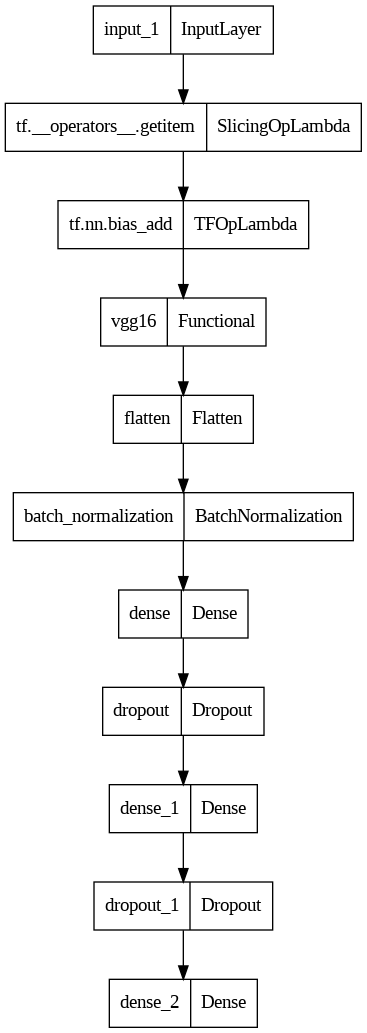

In [ ]:
tf.keras.utils.plot_model(
    vgg_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
efficient_model = tf.keras.models.load_model('/content/drive/MyDrive/CS331_Project/EfficientNet/EfficientNetV2_Adam_New_Final')

In [ ]:
efficient_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']      

In [ ]:
resnet_model = tf.keras.models.load_model('/content/resnet_model_76valacc')

In [ ]:
# resnet_model.summary()

In [ ]:
inception_model = tf.keras.models.load_model('/content/drive/MyDrive/CS331_Project/InceptionV3')

In [ ]:
mobilenet_model = tf.keras.models.load_model('/content/drive/MyDrive/CS331_Project/MobileNetV3Large')

# Test on image

In [ ]:
!mkdir /content/yolo_test/

## Define function test on image

In [ ]:
def test_on_image(source_image_path=None, p=0.2):
    !rm -r /content/yolo_test/*
    if source_image_path is None:
        try:
            filename = take_photo()
            print('Saved to {}'.format(filename))
            # Show the image which was just taken.
            display(Image(filename))
        except Exception as err:
            # Errors will be thrown if the user does not have a webcam or if they do not
            # grant the page permission to access it.
            print(str(err))
        
        source_image_path = '/content/yolov7/photo.jpg'


    with torch.no_grad():
        weights, imgsz = opt['weights'], opt['img-size']
        set_logging()
        device = select_device(opt['device'])
        half = device.type != 'cpu'
        model = attempt_load(weights, map_location=device)  # load FP32 model
        stride = int(model.stride.max())  # model stride
        imgsz = check_img_size(imgsz, s=stride)  # check img_size
        if half:
            model.half()

        names = model.module.names if hasattr(model, 'module') else model.names
        colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
        if device.type != 'cpu':
            model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

        img0 = cv2.imread(source_image_path)
        img = letterbox(img0, imgsz, stride=stride)[0]
        img1 = img0.copy()
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment= False)[0]

        # Apply NMS
        classes = None
        if opt['classes']:
            classes = []
            for class_name in opt['classes']:
                classes.append(names.index(class_name))

        if classes:
            classes = [i for i in range(len(names)) if i not in classes]
        
        
        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        t2 = time_synchronized()
        for i, det in enumerate(pred):
            
            s = ''
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
            if len(det):
                count = 0
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
                for *xyxy, conf, cls in reversed(det):

                    label = f'{names[int(cls)]} {conf:.2f}'
                    cut_img(xyxy, img0, f'/content/yolo_test/image_{count}cut.jpg', p)
                    plot_one_box(xyxy, img1, label=label, color=colors[int(cls)], line_thickness=3)
                    count += 1

    print('YOLOv7 result: ')
    cv2_imshow(img1)
    print('*'*100)
    for e, i in enumerate(os.listdir('/content/yolo_test'), start=1):
        img_test_path = f'/content/yolo_test/{i}'
        print(f'Person {e}')
        image = load_img(img_test_path, target_size=(224, 224))
        image_arr = img_to_array(image)

        # reshape data for the model
        image_exp = np.expand_dims(image_arr, axis=0)
        # image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

        y_vgg16 = predict(preprocess_vgg16_input(np.copy(image_exp)), vgg_model)
        # y_test = predict(preprocess_vgg16_input(np.copy(image_exp)), test_model)
        y_resnet = predict(preprocess_resnet_input(preprocess_vgg16_input(np.copy(image_exp))), resnet_model)
        y_efficient = predict(np.copy(image_exp), efficient_model)
        y_inception = predict(np.copy(image_exp), inception_model)
        y_mobile = predict(np.copy(image_exp), mobilenet_model)
        print(f"VGG16 predict: {y_vgg16}")
        # print(f"VGG16 test predict: {y_test}")
        print(f"EfficientNet predict: {y_efficient}")
        print(f"Resnet50 predict: {y_resnet}")
        print(f"Inception predict: {y_inception}")
        print(f"MobileNet predict: {y_mobile}")

        display(Image(filename=img_test_path))
        print('-'*100)

## Take photo

In [ ]:
test_on_image(p=0)

## Upload image

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
YOLOv7 result: 


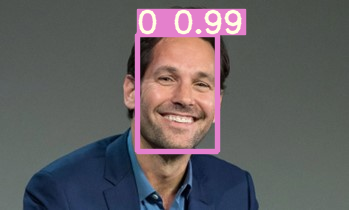

****************************************************************************************************
Person 1
VGG16 predict: 40-44
EfficientNet predict: 30-34
Resnet50 predict: 50-54
Inception predict: 45-49
MobileNet predict: 40-44


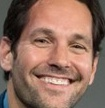

----------------------------------------------------------------------------------------------------


In [ ]:
test_on_image('/content/Picture1.jpg', 0.15)